In [113]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt 
import seaborn as sns
%matplotlib inline
from datetime import datetime
import time 
pd.options.display.max_columns = None
pd.set_option('display.max_rows', 1000)
import scipy.stats
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import StandardScaler

from catboost import CatBoostClassifier
from sklearn.linear_model import BayesianRidge, HuberRegressor, Ridge, OrthogonalMatchingPursuit
from lightgbm import LGBMRegressor
from sklearn.ensemble import GradientBoostingRegressor
from sklearn.model_selection import KFold, cross_val_score
import optuna
#from xgboost import XGBRegressor
#from pycaret.regression import setup, compare_models, models
from scipy import stats
from scipy.stats import boxcox
from scipy.special import boxcox1p
from sklearn import linear_model
from sklearn.linear_model import LinearRegression 
from sklearn.model_selection import train_test_split
from sklearn.model_selection import cross_val_score

In [114]:
df_orders = pd.read_csv('data/Orders.csv',index_col=0)

In [115]:
df_returns = pd.read_csv('data/Returns.csv',index_col=0)

In [116]:
df_orders.head()

,Order.ID,Order.Date,Ship.Date,Ship.Mode,Customer.ID,Customer.Name,Segment,Postal.Code,City,State,Country,Region,Market,Product.ID,Category,Sub.Category,Product.Name,Sales,Quantity,Discount,Profit,Shipping.Cost,Order.Priority
Row.ID,,,,,,,,,,,,,,,,,,,,,,,
40098,CA-2014-AB10015140-41954,11/11/14,11/13/14,First Class,AB-100151402,Aaron Bergman,Consumer,73120.0,Oklahoma City,Oklahoma,United States,Central US,USCA,TEC-PH-5816,Technology,Phones,Samsung Convoy 3,$221.98,2,0.0,$62.15,40.77,High
26341,IN-2014-JR162107-41675,2/5/14,2/7/14,Second Class,JR-162107,Justin Ritter,Corporate,NaN,Wollongong,New South Wales,Australia,Oceania,Asia Pacific,FUR-CH-5379,Furniture,Chairs,"Novimex Executive Leather Armchair, Black","$3,709.40",9,0.1,-$288.77,923.63,Critical
25330,IN-2014-CR127307-41929,10/17/14,10/18/14,First Class,CR-127307,Craig Reiter,Consumer,NaN,Brisbane,Queensland,Australia,Oceania,Asia Pacific,TEC-PH-5356,Technology,Phones,"Nokia Smart Phone, with Caller ID","$5,175.17",9,0.1,$919.97,915.49,Medium
13524,ES-2014-KM1637548-41667,1/28/14,1/30/14,First Class,KM-1637548,Katherine Murray,Home Office,NaN,Berlin,Berlin,Germany,Western Europe,Europe,TEC-PH-5267,Technology,Phones,"Motorola Smart Phone, Cordless","$2,892.51",5,0.1,-$96.54,910.16,Medium
47221,SG-2014-RH9495111-41948,11/5/14,11/6/14,Same Day,RH-9495111,Rick Hansen,Consumer,NaN,Dakar,Dakar,Senegal,Western Africa,Africa,TEC-CO-6011,Technology,Copiers,"Sharp Wireless Fax, High-Speed","$2,832.96",8,0.0,$311.52,903.04,Critical


In [117]:
df_returns.head()

,Order ID,Region
Returned,,
Yes,CA-2012-SA20830140-41210,Central US
Yes,IN-2012-PB19210127-41259,Eastern Asia
Yes,CA-2012-SC20095140-41174,Central US
Yes,IN-2015-JH158207-42140,Oceania
Yes,IN-2014-LC168857-41747,Oceania


In [118]:
df_orders.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 51290 entries, 40098 to 6147
Data columns (total 23 columns):
 #   Column          Non-Null Count  Dtype  
---  ------          --------------  -----  
 0   Order.ID        51290 non-null  object 
 1   Order.Date      51290 non-null  object 
 2   Ship.Date       51290 non-null  object 
 3   Ship.Mode       51290 non-null  object 
 4   Customer.ID     51290 non-null  object 
 5   Customer.Name   51290 non-null  object 
 6   Segment         51290 non-null  object 
 7   Postal.Code     9994 non-null   float64
 8   City            51290 non-null  object 
 9   State           51290 non-null  object 
 10  Country         51290 non-null  object 
 11  Region          51290 non-null  object 
 12  Market          51290 non-null  object 
 13  Product.ID      51290 non-null  object 
 14  Category        51290 non-null  object 
 15  Sub.Category    51290 non-null  object 
 16  Product.Name    51290 non-null  object 
 17  Sales           51290 non-nu

In [119]:
df_orders.columns

Index(['Order.ID', 'Order.Date', 'Ship.Date', 'Ship.Mode', 'Customer.ID',
       'Customer.Name', 'Segment', 'Postal.Code', 'City', 'State', 'Country',
       'Region', 'Market', 'Product.ID', 'Category', 'Sub.Category',
       'Product.Name', 'Sales', 'Quantity', 'Discount', 'Profit',
       'Shipping.Cost', 'Order.Priority'],
      dtype='object')

In [120]:
df_orders['Profit'] = df_orders['Profit'].str.replace('$', '')

<ipython-input-120-2c5c2ad100b1>:1: FutureWarning: The default value of regex will change from True to False in a future version. In addition, single character regular expressions will*not* be treated as literal strings when regex=True.
  df_orders['Profit'] = df_orders['Profit'].str.replace('$', '')


In [121]:
df_orders['Profit'] = df_orders['Profit'].str.replace(',', '')

In [122]:
df_orders.Profit=df_orders.Profit.astype('float64')

In [123]:
df_orders.Sales

Row.ID
40098      $221.98
26341    $3,709.40
25330    $5,175.17
13524    $2,892.51
47221    $2,832.96
           ...    
29002       $65.10
34337       $16.72
31315        $8.56
9596        $13.44
6147        $61.38
Name: Sales, Length: 51290, dtype: object

In [124]:
df_orders['Sales'] = df_orders['Sales'].str.replace('$', '')
df_orders['Sales'] = df_orders['Sales'].str.replace(',', '')
df_orders.Sales=df_orders.Sales.astype('float64')

<ipython-input-124-f31c380abf8f>:1: FutureWarning: The default value of regex will change from True to False in a future version. In addition, single character regular expressions will*not* be treated as literal strings when regex=True.
  df_orders['Sales'] = df_orders['Sales'].str.replace('$', '')


In [125]:
df_orders.Sales

Row.ID
40098     221.98
26341    3709.40
25330    5175.17
13524    2892.51
47221    2832.96
          ...   
29002      65.10
34337      16.72
31315       8.56
9596       13.44
6147       61.38
Name: Sales, Length: 51290, dtype: float64

In [126]:
df_orders.Profit

Row.ID
40098     62.15
26341   -288.77
25330    919.97
13524    -96.54
47221    311.52
          ...  
29002      4.50
34337      3.34
31315      2.48
9596       2.40
6147       1.80
Name: Profit, Length: 51290, dtype: float64

# Problem 2: Inventory Management

In [127]:
df_orders["Order.Date"]=pd.to_datetime(df_orders["Order.Date"])
df_orders["Ship.Date"]=pd.to_datetime(df_orders["Ship.Date"])

In [129]:
df_orders["Ouarters"] = pd.PeriodIndex(df_orders["Order.Date"], freq='Q')

In [130]:
df_orders.head()

,Order.ID,Order.Date,Ship.Date,Ship.Mode,Customer.ID,Customer.Name,Segment,Postal.Code,City,State,Country,Region,Market,Product.ID,Category,Sub.Category,Product.Name,Sales,Quantity,Discount,Profit,Shipping.Cost,Order.Priority,Ouarters
Row.ID,,,,,,,,,,,,,,,,,,,,,,,,
40098,CA-2014-AB10015140-41954,2014-11-11,2014-11-13,First Class,AB-100151402,Aaron Bergman,Consumer,73120.0,Oklahoma City,Oklahoma,United States,Central US,USCA,TEC-PH-5816,Technology,Phones,Samsung Convoy 3,221.98,2,0.0,62.15,40.77,High,2014Q4
26341,IN-2014-JR162107-41675,2014-02-05,2014-02-07,Second Class,JR-162107,Justin Ritter,Corporate,NaN,Wollongong,New South Wales,Australia,Oceania,Asia Pacific,FUR-CH-5379,Furniture,Chairs,"Novimex Executive Leather Armchair, Black",3709.40,9,0.1,-288.77,923.63,Critical,2014Q1
25330,IN-2014-CR127307-41929,2014-10-17,2014-10-18,First Class,CR-127307,Craig Reiter,Consumer,NaN,Brisbane,Queensland,Australia,Oceania,Asia Pacific,TEC-PH-5356,Technology,Phones,"Nokia Smart Phone, with Caller ID",5175.17,9,0.1,919.97,915.49,Medium,2014Q4
13524,ES-2014-KM1637548-41667,2014-01-28,2014-01-30,First Class,KM-1637548,Katherine Murray,Home Office,NaN,Berlin,Berlin,Germany,Western Europe,Europe,TEC-PH-5267,Technology,Phones,"Motorola Smart Phone, Cordless",2892.51,5,0.1,-96.54,910.16,Medium,2014Q1
47221,SG-2014-RH9495111-41948,2014-11-05,2014-11-06,Same Day,RH-9495111,Rick Hansen,Consumer,NaN,Dakar,Dakar,Senegal,Western Africa,Africa,TEC-CO-6011,Technology,Copiers,"Sharp Wireless Fax, High-Speed",2832.96,8,0.0,311.52,903.04,Critical,2014Q4


In [131]:
df_orders.Ouarters.apply(lambda x: str(x)[-1])

Row.ID
40098    4
26341    1
25330    4
13524    1
47221    4
        ..
29002    2
34337    2
31315    3
9596     1
6147     2
Name: Ouarters, Length: 51290, dtype: object

In [132]:
df_orders.Ouarters=df_orders.Ouarters.apply(lambda x: str(x)[-1])

In [133]:
df_orders.head()

,Order.ID,Order.Date,Ship.Date,Ship.Mode,Customer.ID,Customer.Name,Segment,Postal.Code,City,State,Country,Region,Market,Product.ID,Category,Sub.Category,Product.Name,Sales,Quantity,Discount,Profit,Shipping.Cost,Order.Priority,Ouarters
Row.ID,,,,,,,,,,,,,,,,,,,,,,,,
40098,CA-2014-AB10015140-41954,2014-11-11,2014-11-13,First Class,AB-100151402,Aaron Bergman,Consumer,73120.0,Oklahoma City,Oklahoma,United States,Central US,USCA,TEC-PH-5816,Technology,Phones,Samsung Convoy 3,221.98,2,0.0,62.15,40.77,High,4
26341,IN-2014-JR162107-41675,2014-02-05,2014-02-07,Second Class,JR-162107,Justin Ritter,Corporate,NaN,Wollongong,New South Wales,Australia,Oceania,Asia Pacific,FUR-CH-5379,Furniture,Chairs,"Novimex Executive Leather Armchair, Black",3709.40,9,0.1,-288.77,923.63,Critical,1
25330,IN-2014-CR127307-41929,2014-10-17,2014-10-18,First Class,CR-127307,Craig Reiter,Consumer,NaN,Brisbane,Queensland,Australia,Oceania,Asia Pacific,TEC-PH-5356,Technology,Phones,"Nokia Smart Phone, with Caller ID",5175.17,9,0.1,919.97,915.49,Medium,4
13524,ES-2014-KM1637548-41667,2014-01-28,2014-01-30,First Class,KM-1637548,Katherine Murray,Home Office,NaN,Berlin,Berlin,Germany,Western Europe,Europe,TEC-PH-5267,Technology,Phones,"Motorola Smart Phone, Cordless",2892.51,5,0.1,-96.54,910.16,Medium,1
47221,SG-2014-RH9495111-41948,2014-11-05,2014-11-06,Same Day,RH-9495111,Rick Hansen,Consumer,NaN,Dakar,Dakar,Senegal,Western Africa,Africa,TEC-CO-6011,Technology,Copiers,"Sharp Wireless Fax, High-Speed",2832.96,8,0.0,311.52,903.04,Critical,4


In [134]:
df_orders.groupby("Ouarters").Quantity.sum()
#Quantity vs order.date

Ouarters
1    26691
2    41671
3    49121
4    60829
Name: Quantity, dtype: int64

Is there any seasonal trend of inventory in the company?
Q4 highest, Q1 lowest

Is the seasonal trend the same for different categories?
Q4 highest, Q1 lowest

In [135]:
df_orders.Category.value_counts()

Office Supplies    31289
Technology         10141
Furniture           9860
Name: Category, dtype: int64

In [136]:
df_orders.groupby(["Category","Ouarters"]).Quantity.sum()

Category         Ouarters
Furniture        1            5342
                 2            7923
                 3            9327
                 4           12300
Office Supplies  1           16103
                 2           25573
                 3           30209
                 4           36359
Technology       1            5246
                 2            8175
                 3            9585
                 4           12170
Name: Quantity, dtype: int64

In [137]:
df_orders.groupby(["Category","Ouarters"]).Quantity.describe()

count      mean       std  min  25%  50%  75%  \
Category        Ouarters                                                    
Furniture       1          1489.0  3.587643  2.343318  1.0  2.0  3.0  5.0   
                2          2279.0  3.476525  2.188895  1.0  2.0  3.0  5.0   
                3          2668.0  3.495877  2.272655  1.0  2.0  3.0  5.0   
                4          3424.0  3.592290  2.263198  1.0  2.0  3.0  5.0   
Office Supplies 1          4778.0  3.370239  2.264120  1.0  2.0  3.0  4.0   
                2          7469.0  3.423885  2.296978  1.0  2.0  3.0  5.0   
                3          8780.0  3.440661  2.262933  1.0  2.0  3.0  5.0   
                4         10262.0  3.543072  2.311913  1.0  2.0  3.0  5.0   
Technology      1          1560.0  3.362821  2.248604  1.0  2.0  3.0  4.0   
                2          2373.0  3.445006  2.254850  1.0  2.0  3.0  4.0   
                3          2770.0  3.460289  2.250808  1.0  2.0  3.0  5.0   
                4          3438.0  3.539849  2.291275  1.0  2.0  3.0  5.0   

                           max  
Category        Ouarters        
Furniture       1         14.0  
                2         14.0  
                3         14.0  
                4         14.0  
Office Supplies 1         14.0  
                2         14.0  
                3         14.0  
                4         14.0  
Technology      1         14.0  
                2         14.0  
                3         14.0  
                4         14.0

# Problem 3: Why did customers make returns?

In [454]:
df_orders.shape

(51290, 24)

In [455]:
df_returns.shape

(1079, 5)

In [336]:
#df_total.shape

(2202, 26)

In [160]:
#df_total = pd.merge(df_orders, df_returns, on=['Order.ID','Region'])


In [337]:
#df_total2.shape

(2220, 26)

In [377]:
df_total2 = pd.merge(df_orders, df_returns, on=['Order.ID'])
df_total2.drop("Region_y",axis=1)

,Order.ID,Order.Date,Ship.Date,Ship.Mode,Customer.ID,Customer.Name,Segment,Postal.Code,City,State,Country,Region_x,Market,Product.ID,Category,Sub.Category,Product.Name,Sales,Quantity,Discount,Profit,Shipping.Cost,Order.Priority,Ouarters,level_0,index,Returned
0,IN-2012-PB19210127-41259,2012-12-16,2012-12-19,First Class,PB-19210127,Phillip Breyer,Corporate,NaN,Taipei,Taipei City,Taiwan,Eastern Asia,Asia Pacific,FUR-TA-5060,Furniture,Tables,"Lesro Conference Table, with Bottom Storage",1715.16,2,0.0,720.36,725.570,Critical,4,1,1,Yes
1,IN-2012-PB19210127-41259,2012-12-16,2012-12-19,First Class,PB-19210127,Phillip Breyer,Corporate,NaN,Taipei,Taipei City,Taiwan,Eastern Asia,Asia Pacific,FUR-BO-5762,Furniture,Bookcases,"Safco Classic Bookcase, Pine",2197.50,5,0.0,153.75,627.270,Critical,4,1,1,Yes
2,IN-2012-PB19210127-41259,2012-12-16,2012-12-19,First Class,PB-19210127,Phillip Breyer,Corporate,NaN,Taipei,Taipei City,Taiwan,Eastern Asia,Asia Pacific,FUR-TA-5065,Furniture,Tables,"Lesro Round Table, with Bottom Storage",1356.03,3,0.0,311.85,458.970,Critical,4,1,1,Yes
3,IN-2012-PB19210127-41259,2012-12-16,2012-12-19,First Class,PB-19210127,Phillip Breyer,Corporate,NaN,Taipei,Taipei City,Taiwan,Eastern Asia,Asia Pacific,FUR-CH-5454,Furniture,Chairs,"Office Star Swivel Stool, Adjustable",882.15,5,0.0,114.60,203.920,Critical,4,1,1,Yes
4,IN-2012-PB19210127-41259,2012-12-16,2012-12-19,First Class,PB-19210127,Phillip Breyer,Corporate,NaN,Taipei,Taipei City,Taiwan,Eastern Asia,Asia Pacific,TEC-MA-5494,Technology,Machines,"Okidata Calculator, Red",148.32,3,0.0,68.22,25.480,Critical,4,1,1,Yes
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2215,CA-2014-WB21850140-41654,2014-01-15,2014-01-21,Standard Class,WB-218501406,William Brown,Consumer,10011.0,New York City,New York,United States,Eastern US,USCA,OFF-BI-6098,Office Supplies,Binders,"Square Ring Data Binders, Rigid 75 Pt. Covers,...",49.54,3,0.2,17.34,2.670,Medium,1,821,821,Yes
2216,CA-2014-WB21850140-41654,2014-01-15,2014-01-21,Standard Class,WB-218501406,William Brown,Consumer,10011.0,New York City,New York,United States,Eastern US,USCA,OFF-EN-2850,Office Supplies,Envelopes,"#10 Gummed Flap White Envelopes, 100/Box",16.52,4,0.0,7.60,1.690,Medium,1,821,821,Yes
2217,US-2013-SJ2021582-41543,2013-09-26,2013-09-29,First Class,SJ-2021582,Sarah Jordon,Consumer,NaN,Hermosillo,Sonora,Mexico,Central America,LATAM,FUR-FU-3928,Furniture,Furnishings,"Deflect-O Clock, Black",181.12,9,0.4,-75.56,1.085,Medium,3,1076,1076,Yes
2218,CA-2012-ZC21910140-41271,2012-12-28,2013-01-04,Standard Class,ZC-219101402,Zuschuss Carroll,Consumer,60610.0,Chicago,Illinois,United States,Central US,USCA,FUR-FU-6235,Furniture,Furnishings,Tenex Chairmats For Use with Hard Floors,38.98,3,0.6,-50.67,5.290,Low,4,796,796,Yes


In [378]:
df_total2=df_total2.drop("Region_y",axis=1)

In [379]:
df_total2 = df_total2.rename(columns={"Region_x": "Region"})

In [380]:
df_total2.head()

,Order.ID,Order.Date,Ship.Date,Ship.Mode,Customer.ID,Customer.Name,Segment,Postal.Code,City,State,Country,Region,Market,Product.ID,Category,Sub.Category,Product.Name,Sales,Quantity,Discount,Profit,Shipping.Cost,Order.Priority,Ouarters,level_0,index,Returned
0,IN-2012-PB19210127-41259,2012-12-16,2012-12-19,First Class,PB-19210127,Phillip Breyer,Corporate,NaN,Taipei,Taipei City,Taiwan,Eastern Asia,Asia Pacific,FUR-TA-5060,Furniture,Tables,"Lesro Conference Table, with Bottom Storage",1715.16,2,0.0,720.36,725.57,Critical,4,1,1,Yes
1,IN-2012-PB19210127-41259,2012-12-16,2012-12-19,First Class,PB-19210127,Phillip Breyer,Corporate,NaN,Taipei,Taipei City,Taiwan,Eastern Asia,Asia Pacific,FUR-BO-5762,Furniture,Bookcases,"Safco Classic Bookcase, Pine",2197.50,5,0.0,153.75,627.27,Critical,4,1,1,Yes
2,IN-2012-PB19210127-41259,2012-12-16,2012-12-19,First Class,PB-19210127,Phillip Breyer,Corporate,NaN,Taipei,Taipei City,Taiwan,Eastern Asia,Asia Pacific,FUR-TA-5065,Furniture,Tables,"Lesro Round Table, with Bottom Storage",1356.03,3,0.0,311.85,458.97,Critical,4,1,1,Yes
3,IN-2012-PB19210127-41259,2012-12-16,2012-12-19,First Class,PB-19210127,Phillip Breyer,Corporate,NaN,Taipei,Taipei City,Taiwan,Eastern Asia,Asia Pacific,FUR-CH-5454,Furniture,Chairs,"Office Star Swivel Stool, Adjustable",882.15,5,0.0,114.60,203.92,Critical,4,1,1,Yes
4,IN-2012-PB19210127-41259,2012-12-16,2012-12-19,First Class,PB-19210127,Phillip Breyer,Corporate,NaN,Taipei,Taipei City,Taiwan,Eastern Asia,Asia Pacific,TEC-MA-5494,Technology,Machines,"Okidata Calculator, Red",148.32,3,0.0,68.22,25.48,Critical,4,1,1,Yes


In [381]:
df_total2['Year'] = pd.DatetimeIndex(df_total2['Order.Date']).year

In [382]:
df_total2.head()

,Order.ID,Order.Date,Ship.Date,Ship.Mode,Customer.ID,Customer.Name,Segment,Postal.Code,City,State,Country,Region,Market,Product.ID,Category,Sub.Category,Product.Name,Sales,Quantity,Discount,Profit,Shipping.Cost,Order.Priority,Ouarters,level_0,index,Returned,Year
0,IN-2012-PB19210127-41259,2012-12-16,2012-12-19,First Class,PB-19210127,Phillip Breyer,Corporate,NaN,Taipei,Taipei City,Taiwan,Eastern Asia,Asia Pacific,FUR-TA-5060,Furniture,Tables,"Lesro Conference Table, with Bottom Storage",1715.16,2,0.0,720.36,725.57,Critical,4,1,1,Yes,2012
1,IN-2012-PB19210127-41259,2012-12-16,2012-12-19,First Class,PB-19210127,Phillip Breyer,Corporate,NaN,Taipei,Taipei City,Taiwan,Eastern Asia,Asia Pacific,FUR-BO-5762,Furniture,Bookcases,"Safco Classic Bookcase, Pine",2197.50,5,0.0,153.75,627.27,Critical,4,1,1,Yes,2012
2,IN-2012-PB19210127-41259,2012-12-16,2012-12-19,First Class,PB-19210127,Phillip Breyer,Corporate,NaN,Taipei,Taipei City,Taiwan,Eastern Asia,Asia Pacific,FUR-TA-5065,Furniture,Tables,"Lesro Round Table, with Bottom Storage",1356.03,3,0.0,311.85,458.97,Critical,4,1,1,Yes,2012
3,IN-2012-PB19210127-41259,2012-12-16,2012-12-19,First Class,PB-19210127,Phillip Breyer,Corporate,NaN,Taipei,Taipei City,Taiwan,Eastern Asia,Asia Pacific,FUR-CH-5454,Furniture,Chairs,"Office Star Swivel Stool, Adjustable",882.15,5,0.0,114.60,203.92,Critical,4,1,1,Yes,2012
4,IN-2012-PB19210127-41259,2012-12-16,2012-12-19,First Class,PB-19210127,Phillip Breyer,Corporate,NaN,Taipei,Taipei City,Taiwan,Eastern Asia,Asia Pacific,TEC-MA-5494,Technology,Machines,"Okidata Calculator, Red",148.32,3,0.0,68.22,25.48,Critical,4,1,1,Yes,2012


In [384]:
#df_returns=df_returns.reset_index()

In [385]:
#Q3.1
df_total2.groupby(['Year','Returned']).agg({'Profit': 'sum'})

,,Profit
Year,Returned,
2012,Yes,17477.26
2013,Yes,9269.89
2014,Yes,17510.63
2015,Yes,17112.97


In [386]:
df_yearly_profit=df_total2.groupby(['Year','Returned']).agg({'Profit': 'sum'})

In [387]:
df_yearly_profit=df_yearly_profit.reset_index()

<AxesSubplot:xlabel='Year'>

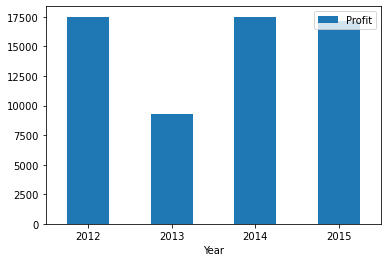

In [388]:
df_yearly_profit.plot.bar(x='Year', y='Profit', rot=0)

In [364]:
df_total2.groupby("Customer.ID").Returned.count()>1

Customer.ID
AA-1031558      False
AA-106451404    False
AA-1064559       True
AA-1064564      False
AA-645137       False
                ...  
WB-218501406     True
WB-2185064      False
YS-2188093      False
ZC-219101402    False
ZD-2192548      False
Name: Returned, Length: 1061, dtype: bool

In [389]:
#3.2 #How many customer returned more than once?
(df_total2.groupby("Customer.ID").Returned.count()>1).sum()

547

In [390]:
#3.2.2 #How many customer returned more than 5 times?
(df_total2.groupby("Customer.ID").Returned.count()>5).sum()

46

In [395]:
df_frequent_returners = pd.DataFrame({'Once': [547], '5Times': [46]})

In [396]:
df_frequent_returners=pd.DataFrame.transpose(df_frequent_returners)

In [397]:
df_frequent_returners

,0
Once,547
5Times,46


<AxesSubplot:>

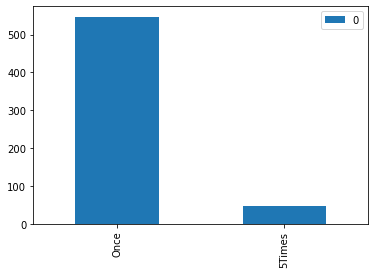

In [398]:
df_frequent_returners.plot.bar()
#plt.xticks(ticks = [1,2], labels = ["Once","5Times"])
#plt.xticks(pop_rank,top10.country,rotation='vertical')

In [399]:
#3.3 Which regions are more likely to return orders?
df_plot_region=df_total2.groupby("Region").Returned.count().sort_values(ascending=False)
df_plot_region

Region
Central America      248
Western Europe       233
Western US           177
Oceania              154
Southeastern Asia    140
Eastern US           134
South America        133
Eastern Asia         131
Southern Europe      112
Southern Asia        111
Western Asia         108
Southern US           83
Northern Europe       76
Central US            74
Caribbean             69
Western Africa        60
North Africa          51
Eastern Europe        42
Southern Africa       25
Eastern Africa        18
Central Africa        17
Canada                15
Central Asia           9
Name: Returned, dtype: int64

<AxesSubplot:xlabel='Region'>

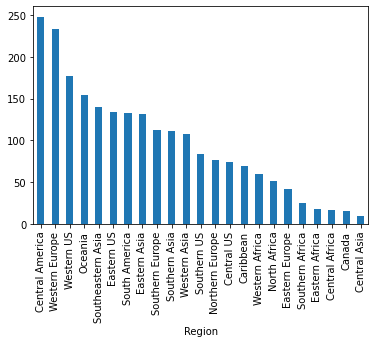

In [400]:
df_plot_region.plot.bar()

In [401]:
#3.4
df_category=df_total2.groupby(["Category","Sub.Category"]).Returned.count().sort_values(ascending=False)
df_category

Category         Sub.Category
Office Supplies  Binders         269
                 Art             217
                 Storage         212
                 Paper           150
Furniture        Chairs          147
Technology       Phones          145
                 Accessories     138
Office Supplies  Labels          137
Furniture        Furnishings     135
                 Bookcases       104
Office Supplies  Supplies        103
                 Fasteners       102
                 Envelopes        99
Technology       Copiers          99
                 Machines         63
Office Supplies  Appliances       59
Furniture        Tables           41
Name: Returned, dtype: int64

<AxesSubplot:ylabel='Category,Sub.Category'>

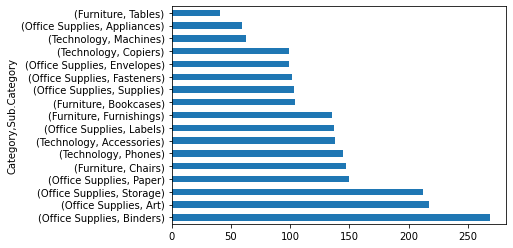

In [402]:
df_category.plot.barh()

In [403]:
pd.DataFrame(df_total2.groupby(["Category","Sub.Category"]).Returned.count().sort_values(ascending=False))

Returned
Category        Sub.Category          
Office Supplies Binders            269
                Art                217
                Storage            212
                Paper              150
Furniture       Chairs             147
Technology      Phones             145
                Accessories        138
Office Supplies Labels             137
Furniture       Furnishings        135
                Bookcases          104
Office Supplies Supplies           103
                Fasteners          102
                Envelopes           99
Technology      Copiers             99
                Machines            63
Office Supplies Appliances          59
Furniture       Tables              41

# Part II

## Problem 4: Feature Engineering

In [488]:
df_train=pd.merge(df_orders, df_returns, on=['Order.ID'], how="left")
df_train.head()

,Order.ID,Order.Date,Ship.Date,Ship.Mode,Customer.ID,Customer.Name,Segment,Postal.Code,City,State,Country,Region_x,Market,Product.ID,Category,Sub.Category,Product.Name,Sales,Quantity,Discount,Profit,Shipping.Cost,Order.Priority,Ouarters,level_0,index,Returned,Region_y
0,CA-2014-AB10015140-41954,2014-11-11,2014-11-13,First Class,AB-100151402,Aaron Bergman,Consumer,73120.0,Oklahoma City,Oklahoma,United States,Central US,USCA,TEC-PH-5816,Technology,Phones,Samsung Convoy 3,221.98,2,0.0,62.15,40.77,High,4,NaN,NaN,NaN,NaN
1,IN-2014-JR162107-41675,2014-02-05,2014-02-07,Second Class,JR-162107,Justin Ritter,Corporate,NaN,Wollongong,New South Wales,Australia,Oceania,Asia Pacific,FUR-CH-5379,Furniture,Chairs,"Novimex Executive Leather Armchair, Black",3709.40,9,0.1,-288.77,923.63,Critical,1,NaN,NaN,NaN,NaN
2,IN-2014-CR127307-41929,2014-10-17,2014-10-18,First Class,CR-127307,Craig Reiter,Consumer,NaN,Brisbane,Queensland,Australia,Oceania,Asia Pacific,TEC-PH-5356,Technology,Phones,"Nokia Smart Phone, with Caller ID",5175.17,9,0.1,919.97,915.49,Medium,4,NaN,NaN,NaN,NaN
3,ES-2014-KM1637548-41667,2014-01-28,2014-01-30,First Class,KM-1637548,Katherine Murray,Home Office,NaN,Berlin,Berlin,Germany,Western Europe,Europe,TEC-PH-5267,Technology,Phones,"Motorola Smart Phone, Cordless",2892.51,5,0.1,-96.54,910.16,Medium,1,NaN,NaN,NaN,NaN
4,SG-2014-RH9495111-41948,2014-11-05,2014-11-06,Same Day,RH-9495111,Rick Hansen,Consumer,NaN,Dakar,Dakar,Senegal,Western Africa,Africa,TEC-CO-6011,Technology,Copiers,"Sharp Wireless Fax, High-Speed",2832.96,8,0.0,311.52,903.04,Critical,4,NaN,NaN,NaN,NaN


In [489]:
df_train.Returned.unique()

array([nan, 'Yes'], dtype=object)

In [490]:
df_train.Returned=df_trin.Returned.fillna("No")

In [491]:
df_train.Returned.unique()

array(['No', 'Yes'], dtype=object)

In [492]:
df_train.head()

,Order.ID,Order.Date,Ship.Date,Ship.Mode,Customer.ID,Customer.Name,Segment,Postal.Code,City,State,Country,Region_x,Market,Product.ID,Category,Sub.Category,Product.Name,Sales,Quantity,Discount,Profit,Shipping.Cost,Order.Priority,Ouarters,level_0,index,Returned,Region_y
0,CA-2014-AB10015140-41954,2014-11-11,2014-11-13,First Class,AB-100151402,Aaron Bergman,Consumer,73120.0,Oklahoma City,Oklahoma,United States,Central US,USCA,TEC-PH-5816,Technology,Phones,Samsung Convoy 3,221.98,2,0.0,62.15,40.77,High,4,NaN,NaN,No,NaN
1,IN-2014-JR162107-41675,2014-02-05,2014-02-07,Second Class,JR-162107,Justin Ritter,Corporate,NaN,Wollongong,New South Wales,Australia,Oceania,Asia Pacific,FUR-CH-5379,Furniture,Chairs,"Novimex Executive Leather Armchair, Black",3709.40,9,0.1,-288.77,923.63,Critical,1,NaN,NaN,No,NaN
2,IN-2014-CR127307-41929,2014-10-17,2014-10-18,First Class,CR-127307,Craig Reiter,Consumer,NaN,Brisbane,Queensland,Australia,Oceania,Asia Pacific,TEC-PH-5356,Technology,Phones,"Nokia Smart Phone, with Caller ID",5175.17,9,0.1,919.97,915.49,Medium,4,NaN,NaN,No,NaN
3,ES-2014-KM1637548-41667,2014-01-28,2014-01-30,First Class,KM-1637548,Katherine Murray,Home Office,NaN,Berlin,Berlin,Germany,Western Europe,Europe,TEC-PH-5267,Technology,Phones,"Motorola Smart Phone, Cordless",2892.51,5,0.1,-96.54,910.16,Medium,1,NaN,NaN,No,NaN
4,SG-2014-RH9495111-41948,2014-11-05,2014-11-06,Same Day,RH-9495111,Rick Hansen,Consumer,NaN,Dakar,Dakar,Senegal,Western Africa,Africa,TEC-CO-6011,Technology,Copiers,"Sharp Wireless Fax, High-Speed",2832.96,8,0.0,311.52,903.04,Critical,4,NaN,NaN,No,NaN


In [493]:
df_train=df_train.drop(["Order.ID","index"], axis=1)

In [494]:
df_train=df_train.drop("level_0", axis=1)

In [495]:
df_train.head()

,Order.Date,Ship.Date,Ship.Mode,Customer.ID,Customer.Name,Segment,Postal.Code,City,State,Country,Region_x,Market,Product.ID,Category,Sub.Category,Product.Name,Sales,Quantity,Discount,Profit,Shipping.Cost,Order.Priority,Ouarters,Returned,Region_y
0,2014-11-11,2014-11-13,First Class,AB-100151402,Aaron Bergman,Consumer,73120.0,Oklahoma City,Oklahoma,United States,Central US,USCA,TEC-PH-5816,Technology,Phones,Samsung Convoy 3,221.98,2,0.0,62.15,40.77,High,4,No,NaN
1,2014-02-05,2014-02-07,Second Class,JR-162107,Justin Ritter,Corporate,NaN,Wollongong,New South Wales,Australia,Oceania,Asia Pacific,FUR-CH-5379,Furniture,Chairs,"Novimex Executive Leather Armchair, Black",3709.40,9,0.1,-288.77,923.63,Critical,1,No,NaN
2,2014-10-17,2014-10-18,First Class,CR-127307,Craig Reiter,Consumer,NaN,Brisbane,Queensland,Australia,Oceania,Asia Pacific,TEC-PH-5356,Technology,Phones,"Nokia Smart Phone, with Caller ID",5175.17,9,0.1,919.97,915.49,Medium,4,No,NaN
3,2014-01-28,2014-01-30,First Class,KM-1637548,Katherine Murray,Home Office,NaN,Berlin,Berlin,Germany,Western Europe,Europe,TEC-PH-5267,Technology,Phones,"Motorola Smart Phone, Cordless",2892.51,5,0.1,-96.54,910.16,Medium,1,No,NaN
4,2014-11-05,2014-11-06,Same Day,RH-9495111,Rick Hansen,Consumer,NaN,Dakar,Dakar,Senegal,Western Africa,Africa,TEC-CO-6011,Technology,Copiers,"Sharp Wireless Fax, High-Speed",2832.96,8,0.0,311.52,903.04,Critical,4,No,NaN


In [496]:
df_train.Region_x.unique()

array(['Central US', 'Oceania', 'Western Europe', 'Western Africa',
       'Western US', 'Southern Asia', 'Western Asia', 'South America',
       'Eastern Asia', 'Southern Europe', 'Eastern Africa',
       'Eastern Europe', 'Northern Europe', 'Central America',
       'Eastern US', 'Caribbean', 'Central Africa', 'Southeastern Asia',
       'Southern US', 'North Africa', 'Southern Africa', 'Canada',
       'Central Asia'], dtype=object)

In [497]:
df_train.Region_y.unique()

array([nan, 'Eastern Asia', 'Oceania', 'Southern US', 'Western Europe',
       'Southern Europe', 'Western Asia', 'Southern Africa',
       'Eastern Europe', 'Southeastern Asia', 'Southern Asia',
       'Northern Europe', 'Central America', 'Eastern US',
       'South America', 'Western US', 'North Africa', 'Central US',
       'Caribbean', 'Central Africa', 'Western Africa', 'Eastern Africa',
       'Eastern Canada', 'Central Asia', 'Western Canada'], dtype=object)

In [498]:
df_train=df_train.drop("Region_y", axis=1)

In [469]:
df_train.head()

,Order.Date,Ship.Date,Ship.Mode,Customer.ID,Customer.Name,Segment,Postal.Code,City,State,Country,Region_x,Market,Product.ID,Category,Sub.Category,Product.Name,Sales,Quantity,Discount,Profit,Shipping.Cost,Order.Priority,Ouarters
0,2014-11-11,2014-11-13,First Class,AB-100151402,Aaron Bergman,Consumer,73120.0,Oklahoma City,Oklahoma,United States,Central US,USCA,TEC-PH-5816,Technology,Phones,Samsung Convoy 3,221.98,2,0.0,62.15,40.77,High,4
1,2014-02-05,2014-02-07,Second Class,JR-162107,Justin Ritter,Corporate,NaN,Wollongong,New South Wales,Australia,Oceania,Asia Pacific,FUR-CH-5379,Furniture,Chairs,"Novimex Executive Leather Armchair, Black",3709.40,9,0.1,-288.77,923.63,Critical,1
2,2014-10-17,2014-10-18,First Class,CR-127307,Craig Reiter,Consumer,NaN,Brisbane,Queensland,Australia,Oceania,Asia Pacific,TEC-PH-5356,Technology,Phones,"Nokia Smart Phone, with Caller ID",5175.17,9,0.1,919.97,915.49,Medium,4
3,2014-01-28,2014-01-30,First Class,KM-1637548,Katherine Murray,Home Office,NaN,Berlin,Berlin,Germany,Western Europe,Europe,TEC-PH-5267,Technology,Phones,"Motorola Smart Phone, Cordless",2892.51,5,0.1,-96.54,910.16,Medium,1
4,2014-11-05,2014-11-06,Same Day,RH-9495111,Rick Hansen,Consumer,NaN,Dakar,Dakar,Senegal,Western Africa,Africa,TEC-CO-6011,Technology,Copiers,"Sharp Wireless Fax, High-Speed",2832.96,8,0.0,311.52,903.04,Critical,4


In [499]:
df_train = df_train.rename(columns={"Region_x": "Region"})

In [500]:
df_train.head()

,Order.Date,Ship.Date,Ship.Mode,Customer.ID,Customer.Name,Segment,Postal.Code,City,State,Country,Region,Market,Product.ID,Category,Sub.Category,Product.Name,Sales,Quantity,Discount,Profit,Shipping.Cost,Order.Priority,Ouarters,Returned
0,2014-11-11,2014-11-13,First Class,AB-100151402,Aaron Bergman,Consumer,73120.0,Oklahoma City,Oklahoma,United States,Central US,USCA,TEC-PH-5816,Technology,Phones,Samsung Convoy 3,221.98,2,0.0,62.15,40.77,High,4,No
1,2014-02-05,2014-02-07,Second Class,JR-162107,Justin Ritter,Corporate,NaN,Wollongong,New South Wales,Australia,Oceania,Asia Pacific,FUR-CH-5379,Furniture,Chairs,"Novimex Executive Leather Armchair, Black",3709.40,9,0.1,-288.77,923.63,Critical,1,No
2,2014-10-17,2014-10-18,First Class,CR-127307,Craig Reiter,Consumer,NaN,Brisbane,Queensland,Australia,Oceania,Asia Pacific,TEC-PH-5356,Technology,Phones,"Nokia Smart Phone, with Caller ID",5175.17,9,0.1,919.97,915.49,Medium,4,No
3,2014-01-28,2014-01-30,First Class,KM-1637548,Katherine Murray,Home Office,NaN,Berlin,Berlin,Germany,Western Europe,Europe,TEC-PH-5267,Technology,Phones,"Motorola Smart Phone, Cordless",2892.51,5,0.1,-96.54,910.16,Medium,1,No
4,2014-11-05,2014-11-06,Same Day,RH-9495111,Rick Hansen,Consumer,NaN,Dakar,Dakar,Senegal,Western Africa,Africa,TEC-CO-6011,Technology,Copiers,"Sharp Wireless Fax, High-Speed",2832.96,8,0.0,311.52,903.04,Critical,4,No


### Step 2 / 4.2

In [501]:
df_train["Order.Date"]=pd.to_datetime(df_train["Order.Date"])
df_train["Ship.Date"]=pd.to_datetime(df_train["Ship.Date"])

In [502]:
df_train["Process.Time"]=df_train["Ship.Date"]-df_train["Order.Date"]

In [503]:
df_train.head()

,Order.Date,Ship.Date,Ship.Mode,Customer.ID,Customer.Name,Segment,Postal.Code,City,State,Country,Region,Market,Product.ID,Category,Sub.Category,Product.Name,Sales,Quantity,Discount,Profit,Shipping.Cost,Order.Priority,Ouarters,Returned,Process.Time
0,2014-11-11,2014-11-13,First Class,AB-100151402,Aaron Bergman,Consumer,73120.0,Oklahoma City,Oklahoma,United States,Central US,USCA,TEC-PH-5816,Technology,Phones,Samsung Convoy 3,221.98,2,0.0,62.15,40.77,High,4,No,2 days
1,2014-02-05,2014-02-07,Second Class,JR-162107,Justin Ritter,Corporate,NaN,Wollongong,New South Wales,Australia,Oceania,Asia Pacific,FUR-CH-5379,Furniture,Chairs,"Novimex Executive Leather Armchair, Black",3709.40,9,0.1,-288.77,923.63,Critical,1,No,2 days
2,2014-10-17,2014-10-18,First Class,CR-127307,Craig Reiter,Consumer,NaN,Brisbane,Queensland,Australia,Oceania,Asia Pacific,TEC-PH-5356,Technology,Phones,"Nokia Smart Phone, with Caller ID",5175.17,9,0.1,919.97,915.49,Medium,4,No,1 days
3,2014-01-28,2014-01-30,First Class,KM-1637548,Katherine Murray,Home Office,NaN,Berlin,Berlin,Germany,Western Europe,Europe,TEC-PH-5267,Technology,Phones,"Motorola Smart Phone, Cordless",2892.51,5,0.1,-96.54,910.16,Medium,1,No,2 days
4,2014-11-05,2014-11-06,Same Day,RH-9495111,Rick Hansen,Consumer,NaN,Dakar,Dakar,Senegal,Western Africa,Africa,TEC-CO-6011,Technology,Copiers,"Sharp Wireless Fax, High-Speed",2832.96,8,0.0,311.52,903.04,Critical,4,No,1 days


In [504]:
df_train["Process.Time"].value_counts()

4 days    14434
5 days    11221
2 days     7026
6 days     6255
3 days     5035
7 days     3057
0 days     2600
1 days     1662
Name: Process.Time, dtype: int64

### Step 3 / 4.3

In [533]:
df_train=df_train.sort_values("Order.Date")
df_train.head(10)

,Order.Date,Ship.Date,Ship.Mode,Customer.ID,Customer.Name,Segment,Postal.Code,City,State,Country,Region,Market,Product.ID,Category,Sub.Category,Product.Name,Sales,Quantity,Discount,Profit,Shipping.Cost,Order.Priority,Ouarters,Returned,Process.Time
22950,2012-01-01,2012-01-08,Standard Class,JH-159857,Joseph Holt,Consumer,NaN,Wagga Wagga,New South Wales,Australia,Oceania,Asia Pacific,OFF-SU-3002,Office Supplies,Supplies,"Acme Trimmer, High Speed",120.37,3,0.1,36.04,9.72,Medium,1,No,7 days
43610,2012-01-01,2012-01-08,Standard Class,JH-159857,Joseph Holt,Consumer,NaN,Wagga Wagga,New South Wales,Australia,Oceania,Asia Pacific,OFF-PA-3990,Office Supplies,Paper,"Eaton Computer Printout Paper, 8.5 x 11",55.24,2,0.1,15.34,1.80,Medium,1,No,7 days
25078,2012-01-01,2012-01-05,Second Class,AT-73557,Annie Thurman,Consumer,NaN,Budapest,Budapest,Hungary,Eastern Europe,Europe,OFF-ST-6230,Office Supplies,Storage,"Tenex Box, Single Width",66.12,4,0.0,29.64,8.17,High,1,No,4 days
31870,2012-01-01,2012-01-08,Standard Class,JH-159857,Joseph Holt,Consumer,NaN,Wagga Wagga,New South Wales,Australia,Oceania,Asia Pacific,FUR-FU-4075,Furniture,Furnishings,"Eldon Light Bulb, Duo Pack",113.67,5,0.1,37.77,4.70,Medium,1,No,7 days
31583,2012-01-01,2012-01-05,Second Class,EM-14140124,Eugene Moren,Home Office,NaN,Stockholm,Stockholm,Sweden,Northern Europe,Europe,OFF-PA-4177,Office Supplies,Paper,"Enermax Note Cards, Premium",44.87,3,0.5,-26.06,4.82,High,1,No,4 days
9352,2012-01-01,2012-01-06,Standard Class,TB-112803,Toby Braunhardt,Consumer,NaN,Constantine,Constantine,Algeria,North Africa,Africa,OFF-ST-6261,Office Supplies,Storage,"Tenex Lockers, Blue",408.30,2,0.0,106.14,35.46,Medium,1,No,5 days
36643,2012-01-02,2012-01-06,Standard Class,MM-726023,Magdelene Morse,Consumer,NaN,St. Catharines,Ontario,Canada,Canada,USCA,TEC-MA-5503,Technology,Machines,"Okidata Inkjet, Wireless",314.22,1,0.0,3.12,24.10,Medium,1,No,4 days
35051,2012-01-03,2012-01-07,Standard Class,LW-699061,Lindsay Williams,Corporate,NaN,Mosul,Ninawa,Iraq,Western Asia,Asia Pacific,OFF-EN-3663,Office Supplies,Envelopes,"Cameo Interoffice Envelope, Set of 50",47.43,1,0.0,17.07,3.57,High,1,No,4 days
3904,2012-01-03,2012-01-07,Standard Class,LW-699061,Lindsay Williams,Corporate,NaN,Mosul,Ninawa,Iraq,Western Asia,Asia Pacific,FUR-CH-5414,Furniture,Chairs,"Novimex Swivel Stool, Set of Two",666.84,4,0.0,253.32,81.26,High,1,No,4 days
22553,2012-01-03,2012-01-09,Standard Class,KL-1664592,Ken Lonsdale,Consumer,NaN,Papakura,Auckland,New Zealand,Oceania,Asia Pacific,FUR-CH-4684,Furniture,Chairs,"Hon Rocking Chair, Set of Two",159.44,2,0.4,-95.68,10.07,Low,1,No,6 days


In [518]:
df_returned_prod=df_train[df_train["Returned"] == 'Yes']
df_returned_prod

,Order.Date,Ship.Date,Ship.Mode,Customer.ID,Customer.Name,Segment,Postal.Code,City,State,Country,Region,Market,Product.ID,Category,Sub.Category,Product.Name,Sales,Quantity,Discount,Profit,Shipping.Cost,Order.Priority,Ouarters,Returned,Process.Time
26,2012-12-16,2012-12-19,First Class,PB-19210127,Phillip Breyer,Corporate,NaN,Taipei,Taipei City,Taiwan,Eastern Asia,Asia Pacific,FUR-TA-5060,Furniture,Tables,"Lesro Conference Table, with Bottom Storage",1715.16,2,0.0,720.36,725.570,Critical,4,Yes,3 days
53,2012-12-16,2012-12-19,First Class,PB-19210127,Phillip Breyer,Corporate,NaN,Taipei,Taipei City,Taiwan,Eastern Asia,Asia Pacific,FUR-BO-5762,Furniture,Bookcases,"Safco Classic Bookcase, Pine",2197.50,5,0.0,153.75,627.270,Critical,4,Yes,3 days
75,2015-05-16,2015-05-18,Second Class,JH-158207,John Huston,Consumer,NaN,Melbourne,Victoria,Australia,Oceania,Asia Pacific,TEC-PH-3147,Technology,Phones,"Apple Smart Phone, Cordless",2863.35,5,0.1,858.90,581.880,Critical,2,Yes,2 days
110,2014-03-29,2014-04-01,First Class,AS-100451408,Aaron Smayling,Corporate,22204.0,Arlington,Virginia,United States,Southern US,USCA,OFF-ST-4516,Office Supplies,Storage,Hanging Personal Folder File,31.40,2,0.0,7.85,3.810,Medium,1,Yes,3 days
113,2014-04-18,2014-04-19,First Class,LC-168857,Lena Creighton,Consumer,NaN,Sydney,New South Wales,Australia,Oceania,Asia Pacific,TEC-CO-6012,Technology,Copiers,"Sharp Wireless Fax, Laser",1601.64,5,0.1,587.19,511.470,Critical,2,Yes,1 days
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
51165,2012-09-12,2012-09-15,Second Class,ME-1732018,Maria Etezadi,Home Office,NaN,Bagé,Rio Grande do Sul,Brazil,South America,LATAM,OFF-ST-4253,Office Supplies,Storage,"Fellowes Box, Wire Frame",12.50,1,0.0,5.36,1.064,Medium,3,Yes,3 days
51183,2013-01-12,2013-01-16,Standard Class,CC-1261027,Corey Catlett,Corporate,NaN,Nantong,Jiangsu,China,Eastern Asia,Asia Pacific,OFF-LA-5387,Office Supplies,Labels,"Novimex Legal Exhibit Labels, 5000 Label Set",10.86,1,0.0,5.43,1.060,High,1,Yes,4 days
51224,2012-12-28,2013-01-04,Standard Class,ZC-219101402,Zuschuss Carroll,Consumer,60610.0,Chicago,Illinois,United States,Central US,USCA,FUR-FU-6235,Furniture,Furnishings,Tenex Chairmats For Use with Hard Floors,38.98,3,0.6,-50.67,5.290,Low,4,Yes,7 days
51247,2014-07-26,2014-07-30,Standard Class,PM-894038,Paul MacIntyre,Consumer,NaN,Alexandria,Al Iskandariyah,Egypt,North Africa,Africa,OFF-AR-5922,Office Supplies,Art,"Sanford Pencil Sharpener, Fluorescent",25.83,1,0.0,9.03,1.050,Medium,3,Yes,4 days


In [520]:
df_returned_prod.Returned.unique()

array(['Yes'], dtype=object)

In [526]:
df_returned_prod_by_id=pd.DataFrame(df_returned_prod.groupby("Product.ID").Returned.count())
df_returned_prod_by_id

,Returned
Product.ID,
FUR-BO-3176,1
FUR-BO-3615,1
FUR-BO-3616,1
FUR-BO-3621,1
FUR-BO-3624,2
...,...
TEC-PH-6348,1
TEC-PH-6364,1
TEC-PH-6365,1


In [538]:
df_returned_prod_by_id = df_returned_prod_by_id.rename(columns={"Returned": "Return Count"})

In [540]:
df_train_returned=pd.merge(df_train, df_returned_prod_by_id, on="Product.ID" ,how="left")
df_train_returned.head()

,Order.Date,Ship.Date,Ship.Mode,Customer.ID,Customer.Name,Segment,Postal.Code,City,State,Country,Region,Market,Product.ID,Category,Sub.Category,Product.Name,Sales,Quantity,Discount,Profit,Shipping.Cost,Order.Priority,Ouarters,Returned,Process.Time,Return Count
0,2012-01-01,2012-01-08,Standard Class,JH-159857,Joseph Holt,Consumer,NaN,Wagga Wagga,New South Wales,Australia,Oceania,Asia Pacific,OFF-SU-3002,Office Supplies,Supplies,"Acme Trimmer, High Speed",120.37,3,0.1,36.04,9.72,Medium,1,No,7 days,NaN
1,2012-01-01,2012-01-08,Standard Class,JH-159857,Joseph Holt,Consumer,NaN,Wagga Wagga,New South Wales,Australia,Oceania,Asia Pacific,OFF-PA-3990,Office Supplies,Paper,"Eaton Computer Printout Paper, 8.5 x 11",55.24,2,0.1,15.34,1.80,Medium,1,No,7 days,NaN
2,2012-01-01,2012-01-05,Second Class,AT-73557,Annie Thurman,Consumer,NaN,Budapest,Budapest,Hungary,Eastern Europe,Europe,OFF-ST-6230,Office Supplies,Storage,"Tenex Box, Single Width",66.12,4,0.0,29.64,8.17,High,1,No,4 days,NaN
3,2012-01-01,2012-01-08,Standard Class,JH-159857,Joseph Holt,Consumer,NaN,Wagga Wagga,New South Wales,Australia,Oceania,Asia Pacific,FUR-FU-4075,Furniture,Furnishings,"Eldon Light Bulb, Duo Pack",113.67,5,0.1,37.77,4.70,Medium,1,No,7 days,2.0
4,2012-01-01,2012-01-05,Second Class,EM-14140124,Eugene Moren,Home Office,NaN,Stockholm,Stockholm,Sweden,Northern Europe,Europe,OFF-PA-4177,Office Supplies,Paper,"Enermax Note Cards, Premium",44.87,3,0.5,-26.06,4.82,High,1,No,4 days,2.0


In [541]:
df_train_returned["Return Count"].value_counts()

1.0     16007
2.0      8351
3.0      3715
4.0       869
5.0       379
12.0      227
6.0       130
9.0        77
Name: Return Count, dtype: int64

In [542]:
df_train_returned["Return Count"].unique()

array([nan,  2.,  1.,  3.,  6.,  5.,  4., 12.,  9.])

In [543]:
df_train_returned["Return Count"]=df_train_returned["Return Count"].fillna(0)

In [545]:
df_train_returned.head()

,Order.Date,Ship.Date,Ship.Mode,Customer.ID,Customer.Name,Segment,Postal.Code,City,State,Country,Region,Market,Product.ID,Category,Sub.Category,Product.Name,Sales,Quantity,Discount,Profit,Shipping.Cost,Order.Priority,Ouarters,Returned,Process.Time,Return Count
0,2012-01-01,2012-01-08,Standard Class,JH-159857,Joseph Holt,Consumer,NaN,Wagga Wagga,New South Wales,Australia,Oceania,Asia Pacific,OFF-SU-3002,Office Supplies,Supplies,"Acme Trimmer, High Speed",120.37,3,0.1,36.04,9.72,Medium,1,No,7 days,0.0
1,2012-01-01,2012-01-08,Standard Class,JH-159857,Joseph Holt,Consumer,NaN,Wagga Wagga,New South Wales,Australia,Oceania,Asia Pacific,OFF-PA-3990,Office Supplies,Paper,"Eaton Computer Printout Paper, 8.5 x 11",55.24,2,0.1,15.34,1.80,Medium,1,No,7 days,0.0
2,2012-01-01,2012-01-05,Second Class,AT-73557,Annie Thurman,Consumer,NaN,Budapest,Budapest,Hungary,Eastern Europe,Europe,OFF-ST-6230,Office Supplies,Storage,"Tenex Box, Single Width",66.12,4,0.0,29.64,8.17,High,1,No,4 days,0.0
3,2012-01-01,2012-01-08,Standard Class,JH-159857,Joseph Holt,Consumer,NaN,Wagga Wagga,New South Wales,Australia,Oceania,Asia Pacific,FUR-FU-4075,Furniture,Furnishings,"Eldon Light Bulb, Duo Pack",113.67,5,0.1,37.77,4.70,Medium,1,No,7 days,2.0
4,2012-01-01,2012-01-05,Second Class,EM-14140124,Eugene Moren,Home Office,NaN,Stockholm,Stockholm,Sweden,Northern Europe,Europe,OFF-PA-4177,Office Supplies,Paper,"Enermax Note Cards, Premium",44.87,3,0.5,-26.06,4.82,High,1,No,4 days,2.0


In [547]:
df_train_returned["Return Count"]=df_train_returned["Return Count"].astype(int)

In [548]:
df_train_returned.head()

,Order.Date,Ship.Date,Ship.Mode,Customer.ID,Customer.Name,Segment,Postal.Code,City,State,Country,Region,Market,Product.ID,Category,Sub.Category,Product.Name,Sales,Quantity,Discount,Profit,Shipping.Cost,Order.Priority,Ouarters,Returned,Process.Time,Return Count
0,2012-01-01,2012-01-08,Standard Class,JH-159857,Joseph Holt,Consumer,NaN,Wagga Wagga,New South Wales,Australia,Oceania,Asia Pacific,OFF-SU-3002,Office Supplies,Supplies,"Acme Trimmer, High Speed",120.37,3,0.1,36.04,9.72,Medium,1,No,7 days,0
1,2012-01-01,2012-01-08,Standard Class,JH-159857,Joseph Holt,Consumer,NaN,Wagga Wagga,New South Wales,Australia,Oceania,Asia Pacific,OFF-PA-3990,Office Supplies,Paper,"Eaton Computer Printout Paper, 8.5 x 11",55.24,2,0.1,15.34,1.80,Medium,1,No,7 days,0
2,2012-01-01,2012-01-05,Second Class,AT-73557,Annie Thurman,Consumer,NaN,Budapest,Budapest,Hungary,Eastern Europe,Europe,OFF-ST-6230,Office Supplies,Storage,"Tenex Box, Single Width",66.12,4,0.0,29.64,8.17,High,1,No,4 days,0
3,2012-01-01,2012-01-08,Standard Class,JH-159857,Joseph Holt,Consumer,NaN,Wagga Wagga,New South Wales,Australia,Oceania,Asia Pacific,FUR-FU-4075,Furniture,Furnishings,"Eldon Light Bulb, Duo Pack",113.67,5,0.1,37.77,4.70,Medium,1,No,7 days,2
4,2012-01-01,2012-01-05,Second Class,EM-14140124,Eugene Moren,Home Office,NaN,Stockholm,Stockholm,Sweden,Northern Europe,Europe,OFF-PA-4177,Office Supplies,Paper,"Enermax Note Cards, Premium",44.87,3,0.5,-26.06,4.82,High,1,No,4 days,2


# Problem 5: Fitting Models

In [ ]:
#from the Model Selection lecture notebook
from sklearn.model_selection import KFold, StratifiedKFold
from sklearn.linear_model import LogisticRegression
skfold = StratifiedKFold(n_splits=3, shuffle=True)

from sklearn.model_selection import cross_val_score

lm = LogisticRegression(C=1)
scores = cross_val_score(lm, X_train, y_train, cv=skfold)